<a href="https://colab.research.google.com/github/jahidhasanlinix/Sentiment-RLHF-GPT2/blob/main/RLHF_Sentiment_Reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install transformers trl accelerate matplotlib -q

In [1]:
import torch
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
from transformers import pipeline as hf_pipeline
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, set_seed
)
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
import matplotlib.pyplot as plt
from transformers import logging
logging.set_verbosity_error()

In [2]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

🚀 Using device: cuda


In [3]:
class RLHFResearchPipeline:
    def __init__(self, model_name="gpt2", reward_model_name="cardiffnlp/twitter-roberta-base-sentiment-latest",
                 max_length=64, batch_size=4):
        self.model_name = model_name
        self.reward_model_name = reward_model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self._setup_models()

    def _setup_models(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLMWithValueHead.from_pretrained(
            self.model_name,
            device_map="auto"
        )
        self.ref_model = create_reference_model(self.model)
        self.reward_model = hf_pipeline(
            "sentiment-analysis",
            model=self.reward_model_name,
            return_all_scores=True,
            device=0 if torch.cuda.is_available() else -1
        )
        print("✅ Models loaded successfully!")

    def setup_ppo_trainer(self, learning_rate=1e-5):
        config = PPOConfig(
            model_name=self.model_name,
            learning_rate=learning_rate,
            batch_size=self.batch_size,
            mini_batch_size=1,
            gradient_accumulation_steps=1,
            ppo_epochs=4
        )
        self.ppo_trainer = PPOTrainer(
            config=config,
            model=self.model,
            ref_model=self.ref_model,
            tokenizer=self.tokenizer,
        )
        print("🎯 PPO Trainer initialized!")

    def generate_response(self, prompt: str, max_new_tokens=50) -> Tuple[str, torch.Tensor]:
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=self.max_length, truncation=True, padding=True).to(device)
        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )
        generated_tokens = output[0][inputs['input_ids'].shape[-1]:]
        response = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return response, generated_tokens

    def compute_reward(self, responses: List[str]) -> List[float]:
      rewards = []
      for response in responses:
          try:
              sentiment_scores = self.reward_model(response)
              if isinstance(sentiment_scores, list) and isinstance(sentiment_scores[0], list):
                  scores = sentiment_scores[0]
              else:
                  scores = []
              positive_score = next((s['score'] for s in scores if s['label'].upper() in ['POSITIVE', 'LABEL_2']), 0.0)
              reward = (positive_score - 0.5) * 2

              # Penalize repetition
              unique_tokens = len(set(response.split()))
              total_tokens = len(response.split())
              diversity_score = unique_tokens / (total_tokens + 1e-5)
              repetition_penalty = 1.0 if diversity_score < 0.5 else 0.0
              reward -= repetition_penalty  # Lower reward if too repetitive

              rewards.append(reward)
          except Exception as e:
              print(f"⚠️ Error computing reward: {e}")
              rewards.append(0.0)
      return rewards

    def train_step(self, prompts: List[str], steps=60):
      avg_rewards = []  # Store average rewards for each step

      for step in tqdm(range(steps), desc="Training RLHF"):
          batch_prompts = prompts[:self.batch_size]
          responses, responses_tokenized = [], []

          for prompt in batch_prompts:
              response, _ = self.generate_response(prompt)
              responses.append(response)
              # Ensure tokenized responses are LongTensors
              responses_tokenized.append(
                  self.tokenizer(response, return_tensors="pt").input_ids[0].to(torch.long)
              )

          # Ensure tokenized prompts are LongTensors
          tokenized_prompts = [
              self.tokenizer(p, return_tensors="pt").input_ids[0].to(torch.long)
              for p in batch_prompts
          ]

          # Compute rewards and convert to float tensors on the correct device
          rewards_raw = self.compute_reward(responses)
          device = next(self.model.parameters()).device
          rewards = [torch.tensor(r, dtype=torch.float32).to(device) for r in rewards_raw]

          try:
              # PPO training step
              stats = self.ppo_trainer.step(tokenized_prompts, responses_tokenized, rewards)
              avg_reward = float(torch.mean(torch.tensor(rewards_raw)))
              avg_rewards.append(avg_reward)

              print(f"✅ Step {step} | Avg reward: {avg_reward:.3f}")
              print(f"📝 Prompt: {batch_prompts[0]}")
              print(f"💬 Response: {responses[0]}")
              print(f"🎯 Reward: {rewards_raw[0]:.3f}")
              print("-" * 50)

          except Exception as e:
              print(f"❌ PPO step error: {e}")

      # 📈 Plot average reward per step after training
      plt.figure(figsize=(10, 5))
      plt.plot(range(len(avg_rewards)), avg_rewards, marker='o', color='blue')
      plt.title("Average Reward Per Training Step")
      plt.xlabel("Training Step")
      plt.ylabel("Average Reward")
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def evaluate_model(self, prompts: List[str]):
        print("📊 Evaluating model performance...")
        rewards = []
        for prompt in prompts:
            response, _ = self.generate_response(prompt)
            reward = self.compute_reward([response])[0]
            print(f"📝 Prompt: {prompt}")
            print(f"💬 Response: {response}")
            print(f"🎯 Reward: {reward:.3f}")
            rewards.append(reward)
        print(f"\n📈 Avg Reward: {np.mean(rewards):.3f}")


In [4]:
rlhf_pipeline = RLHFResearchPipeline(model_name="gpt2")
rlhf_pipeline.setup_ppo_trainer(learning_rate=1e-5)

✅ Models loaded successfully!
🎯 PPO Trainer initialized!


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:273: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


In [5]:
training_prompts = [
    "Tell me about your day:",
    "What's your opinion on helping others?",
    "Describe a beautiful day on Japan:",
    "How do you handle difficulties?"
]

In [6]:
test_prompts = [
    "What's the best way to start the day?",
    "How do you deal with stress?",
    "What's your advice for happiness?"
]

In [7]:
print("\n📊 Evaluation before training:")
rlhf_pipeline.evaluate_model(test_prompts)


📊 Evaluation before training:
📊 Evaluating model performance...
📝 Prompt: What's the best way to start the day?
💬 Response:  How about a great way to get the most out of your day?

There are a couple of ways you can go about this. One way is to go about it with the right mindset, be aware of your thoughts, be open to new
🎯 Reward: 0.733
📝 Prompt: How do you deal with stress?
💬 Response: 

It's a huge part of what we do. Stress is one of the last things we deal with and it's a huge part of what's going on in our lives. I'm usually able to control the flow of my life. So
🎯 Reward: -0.641
📝 Prompt: What's your advice for happiness?
💬 Response: 

1. Keep your eyes open

Not everyone has the same kind of experience with happiness. Sometimes it's best to avoid being told you're not happy and instead focus on finding the right way to experience it. That way, you're
🎯 Reward: -0.019

📈 Avg Reward: 0.024



🚀 Starting RLHF training...


Training RLHF:   2%|▏         | 1/60 [00:03<03:50,  3.91s/it]

✅ Step 0 | Avg reward: 0.118
📝 Prompt: Tell me about your day:
💬 Response: 

I was with a friend for a couple of days. The first thing I did was go to a party with my friend and I was like "You can go to a party." I was like "Yeah, it's totally fine." She
🎯 Reward: 0.183
--------------------------------------------------


Training RLHF:   3%|▎         | 2/60 [00:07<03:33,  3.67s/it]

✅ Step 1 | Avg reward: -0.160
📝 Prompt: Tell me about your day:
💬 Response: 

"We're trying to get a little more out of our day.
"So when you're out on the road you're not in a bad mood, you're in a good mood, you're in a good place.
"
🎯 Reward: 0.389
--------------------------------------------------


Training RLHF:   5%|▌         | 3/60 [00:10<03:25,  3.60s/it]

✅ Step 2 | Avg reward: -0.294
📝 Prompt: Tell me about your day:
💬 Response:  I don't have the time to read this.

I don't have the time to read this.

I have the time to read it.
I've read every single thing.


I've read every single thing.
🎯 Reward: -1.894
--------------------------------------------------


Training RLHF:   7%|▋         | 4/60 [00:14<03:22,  3.61s/it]

✅ Step 3 | Avg reward: 0.147
📝 Prompt: Tell me about your day:
💬 Response: 

"I'm going to be getting a lot of help with [my mom's] life. I'm going to go to a lot of business meetings and get my mom's car fixed up. We'll be having a lot of money tonight
🎯 Reward: 0.742
--------------------------------------------------


Training RLHF:   8%|▊         | 5/60 [00:18<03:26,  3.76s/it]

✅ Step 4 | Avg reward: -0.234
📝 Prompt: Tell me about your day:
💬 Response:  What you've been working on?

Alex: Hello?

M: No, I'll see you later.

Alex: I'll see you soon.

Alex: Oh, but I must... I must have had a
🎯 Reward: -0.627
--------------------------------------------------


Training RLHF:  10%|█         | 6/60 [00:22<03:19,  3.70s/it]

✅ Step 5 | Avg reward: -0.152
📝 Prompt: Tell me about your day:
💬 Response: 

Matt: Yeah, yeah. Yeah, yeah.

Mitch: Yeah, you know, it's a lot of work.

Matt: Yeah, yeah.

Matt: Yeah, yeah.

Mitch:
🎯 Reward: -0.610
--------------------------------------------------


Training RLHF:  12%|█▏        | 7/60 [00:25<03:12,  3.64s/it]

✅ Step 6 | Avg reward: -0.340
📝 Prompt: Tell me about your day:
💬 Response: 

MR. BUSH: My name is Mark.

QUESTION: That's my name?

MR. BUSH: Yes.
QUESTION: About the name?

MR. BUSH: Yes.


🎯 Reward: -0.723
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (151.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (399.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (406.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  13%|█▎        | 8/60 [00:29<03:18,  3.81s/it]

✅ Step 7 | Avg reward: -0.216
📝 Prompt: Tell me about your day:
💬 Response:  you know, I get myself a lot of different things.

A: [Laughs] Yeah, that's why I've got a lot of different things.

R: You know, I have two big, big, big days.
🎯 Reward: -0.170
--------------------------------------------------


Training RLHF:  15%|█▌        | 9/60 [00:33<03:09,  3.71s/it]

✅ Step 8 | Avg reward: -0.589
📝 Prompt: Tell me about your day:
💬 Response: 

MATTNANCY. DAVID'S. I mean, you don't have any other day?

MMATT. No.

QUESTION.

UNKNOWN.

QUESTION.



🎯 Reward: -0.808
--------------------------------------------------


Training RLHF:  17%|█▋        | 10/60 [00:36<03:04,  3.69s/it]

✅ Step 9 | Avg reward: 0.417
📝 Prompt: Tell me about your day:
💬 Response: 

M: Oh, it's kind of a good day.

MR. HARRIS:
I'll be right back up in a minute.

MR. HARRIS: Yeah.

MR. HARRIS
🎯 Reward: 0.841
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.52) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (129.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  18%|█▊        | 11/60 [00:41<03:09,  3.86s/it]

✅ Step 10 | Avg reward: 0.034
📝 Prompt: Tell me about your day:
💬 Response: 

JUANUS.

COOPER.

Morning, you're just right.


DONALD TRUMP.


Morning.

Morning, you're just right.

DONALD TRUMP.


🎯 Reward: 0.685
--------------------------------------------------


Training RLHF:  20%|██        | 12/60 [00:50<04:26,  5.55s/it]

✅ Step 11 | Avg reward: 0.087
📝 Prompt: Tell me about your day:
💬 Response:  I have a couple of days this week and I'm at home and you're on. Is it Saturday?

Q.

Q.

A.

Q.

Q.


SORRAGE:
🎯 Reward: -0.704
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (31.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (5163.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (19940.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  22%|██▏       | 13/60 [00:54<04:00,  5.12s/it]

✅ Step 12 | Avg reward: -0.221
📝 Prompt: Tell me about your day:
💬 Response:  morning, you're making the breakfast.

DANTHONY

Morning.

DANNY

Morning.

DANNY

Morning.

DANNYNY

Morning.

Q

🎯 Reward: 0.279
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1163.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1563.03) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  23%|██▎       | 14/60 [00:58<03:34,  4.66s/it]

✅ Step 13 | Avg reward: -0.239
📝 Prompt: Tell me about your day:
💬 Response: 

President Obama.
Yours.
Mr. Trump.

Mr. Trump.

Mr. Trump.

Mr. Trump.

Mr. Trump.
Mr. Trump.

Mr. Trump.

🎯 Reward: -1.257
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (32.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (97.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (152.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  25%|██▌       | 15/60 [01:01<03:14,  4.32s/it]

✅ Step 14 | Avg reward: -0.152
📝 Prompt: Tell me about your day:
💬 Response: 

Teddy

Kanye

Kanye

Seat

Kanye

ChCh


You gotta

Teddy

Seat

Kanye


YEAH

D
🎯 Reward: 0.110
--------------------------------------------------


Training RLHF:  27%|██▋       | 16/60 [01:06<03:08,  4.28s/it]

✅ Step 15 | Avg reward: -0.388
📝 Prompt: Tell me about your day:
💬 Response: 

Mr. Trump

The Donald

The Donald
Mr. Trump

Mr. Trump


Mr. Trump

Mr. Trump

Mr. Trump

Mr. Trump

Mr. Trump


🎯 Reward: -1.784
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (26.93) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  28%|██▊       | 17/60 [01:17<04:40,  6.51s/it]

✅ Step 16 | Avg reward: -0.687
📝 Prompt: Tell me about your day:
💬 Response: 

[Breeder] John M. DeNardo

WHY AMENIE


AMIE


[Breeder] John M.

WHY AMEN AMENIE

AM

[Bre
🎯 Reward: -0.824
--------------------------------------------------


Training RLHF:  30%|███       | 18/60 [01:21<03:57,  5.65s/it]

✅ Step 17 | Avg reward: -0.557
📝 Prompt: Tell me about your day:
💬 Response:  Day Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning
🎯 Reward: -1.091
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (155.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (104.61) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (156.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (275.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (156.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  32%|███▏      | 19/60 [01:25<03:27,  5.05s/it]

✅ Step 18 | Avg reward: -0.811
📝 Prompt: Tell me about your day:
💬 Response: 

 White House press secretary Sean Spicer.

FLORA FLOROWEYE

PRESIDENT OBAMA

HOM


 WTF

PRESIDENT OBAMA





PRESIDENT OBAMA
🎯 Reward: -0.870
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (159.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (82.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (142.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (670.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (873.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average rat

✅ Step 19 | Avg reward: -0.827
📝 Prompt: Tell me about your day:
💬 Response: 

* My day.

.

.


.

.


.
.

.

.


.
.
.
.

.

.
.

🎯 Reward: -1.461
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (16.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (687.81) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (695.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  35%|███▌      | 21/60 [01:32<02:53,  4.44s/it]

✅ Step 20 | Avg reward: 0.224
📝 Prompt: Tell me about your day:
💬 Response:  My office.

HARRIS: Yeah.


ARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARRARR
🎯 Reward: -0.272
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (2437.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (4604.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (5492.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  37%|███▋      | 22/60 [01:36<02:39,  4.19s/it]

✅ Step 21 | Avg reward: 0.042
📝 Prompt: Tell me about your day:
💬 Response:  Have you got a day to do?

T. J. T.


T.

AM

.

AM

AM

AM


AM
AM

.

AM


🎯 Reward: -0.426
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (42.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (103.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (342.61) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  38%|███▊      | 23/60 [01:40<02:28,  4.03s/it]

✅ Step 22 | Avg reward: -1.051
📝 Prompt: Tell me about your day:
💬 Response:  I'm doing my job.

PATRICK MOY

I'm working.

The

THE

What's your name?

PATRICK MOY


I'm a

THE
🎯 Reward: -0.095
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (547.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (21212.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (82342.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  40%|████      | 24/60 [01:44<02:26,  4.08s/it]

✅ Step 23 | Avg reward: -0.087
📝 Prompt: Tell me about your day:
💬 Response:  It's a good start— I woke up at breakfast— I've got some news today, and I've got some news now. You know, we're going to be shooting more later tonight. Tonight.

COCOBOY:
🎯 Reward: 0.932
--------------------------------------------------


Training RLHF:  42%|████▏     | 25/60 [01:47<02:17,  3.93s/it]

✅ Step 24 | Avg reward: -0.921
📝 Prompt: Tell me about your day:
💬 Response:  Tuesday morning I was getting a call from Dr. Johnson. He said that's a week off. But I've been off doing some stuff. So I'm trying to get my time off when I'm ready to get back into the gym. No
🎯 Reward: -0.829
--------------------------------------------------


Training RLHF:  43%|████▎     | 26/60 [01:51<02:10,  3.84s/it]

✅ Step 25 | Avg reward: -0.850
📝 Prompt: Tell me about your day:
💬 Response:  I'm up, doing a book and I'm doing a book.


Captain America: Hey, you're working.

Captain America: You're doing a book.
Captain Marvel: I was working on a book.


🎯 Reward: -0.229
--------------------------------------------------


Training RLHF:  45%|████▌     | 27/60 [01:55<02:11,  3.98s/it]

✅ Step 26 | Avg reward: -0.108
📝 Prompt: Tell me about your day:
💬 Response:  [Cue] A little bit of my day. A little bit of the day. [Cue] [Intimidation of a woman.] I'm not going to be a baby again. [Cue] [Intimidation of a
🎯 Reward: -0.876
--------------------------------------------------


Training RLHF:  47%|████▋     | 28/60 [01:59<02:03,  3.86s/it]

✅ Step 27 | Avg reward: -1.105
📝 Prompt: Tell me about your day:
💬 Response:  "The Hobbit: An introduction of the new feature about the new feature about the new feature about You're Not Going to Make It In The Hobbit: The Hobbit - - - - - - - - - - - - - - - - - -
🎯 Reward: -1.674
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  48%|████▊     | 29/60 [02:02<01:56,  3.76s/it]

✅ Step 28 | Avg reward: -0.935
📝 Prompt: Tell me about your day:
💬 Response: 

- I'm off for a bit.
- (You're off for a bit.)

- (Yeah.

- (You're off for a bit.)

- (I'm off.)

- (Yeah
🎯 Reward: -1.725
--------------------------------------------------


Training RLHF:  50%|█████     | 30/60 [02:07<01:56,  3.88s/it]

✅ Step 29 | Avg reward: -0.986
📝 Prompt: Tell me about your day:
💬 Response:  Thursday afternoon.

Mr. M. M M.

Mr. M. M.

Mr. M M.

You're not doing any of that?

Mr. M. M. M.

Mr
🎯 Reward: -0.872
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (33.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (112.31) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (108.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  52%|█████▏    | 31/60 [02:10<01:49,  3.78s/it]

✅ Step 30 | Avg reward: -1.232
📝 Prompt: Tell me about your day:
💬 Response:  Tuesday, Wednesday, Thursday, Friday, evening.

Captain, I'm off to the office.

Captain, I'm off to the office.

Captain, Captain, I'm off to the office.

Captain, I
🎯 Reward: -1.380
--------------------------------------------------


Training RLHF:  53%|█████▎    | 32/60 [02:14<01:44,  3.72s/it]

✅ Step 31 | Avg reward: -0.781
📝 Prompt: Tell me about your day:
💬 Response:  Dinner today. Mr. SIRIEL I'm being up early now. Sir. SIRIEL Come on. Mr. SIRIEL I'm up. I'm up up up up up up up up up up up up up
🎯 Reward: -0.911
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (10.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  55%|█████▌    | 33/60 [02:18<01:42,  3.79s/it]

✅ Step 32 | Avg reward: -1.056
📝 Prompt: Tell me about your day:
💬 Response:  You're talking about that day.

Mr. Carter: Yes.


Mr. Carter: Yes.
Mr. Carter: (Convenience show)
Mr. (In the hotel room. )

Mr. Carter
🎯 Reward: -0.771
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  57%|█████▋    | 34/60 [02:21<01:37,  3.75s/it]

✅ Step 33 | Avg reward: -1.366
📝 Prompt: Tell me about your day:
💬 Response:  Morning Monday Morning Tuesday Tuesday Monday

Morning Tuesday Tuesday Tuesday Monday Tuesday Tuesday Wednesday Thursday Friday Saturday Sunday Sunday Monday Tuesday Tuesday Wednesday Wednesday Thursday Thursday Thursday Friday Saturday Sunday Saturday Friday Saturday Saturday Sunday Monday Monday Tuesday Wednesday Thursday Friday Friday Saturday Saturday Sunday Sunday Monday Tuesday
🎯 Reward: -1.609
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (22.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  58%|█████▊    | 35/60 [02:25<01:32,  3.69s/it]

✅ Step 34 | Avg reward: -1.141
📝 Prompt: Tell me about your day:
💬 Response:  Sunday

Doctor Strange: Hello Doctor

Doctor Strange: Good morning Doctor

Doctor Strange: Good morning Doctor Strange


Doctor Strange: Good morning Doctor Strange

Doctor Strange: Good morning Doctor Strange Doctor Strange

Doctor Strange
🎯 Reward: -0.600
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (13.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (25.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  60%|██████    | 36/60 [02:29<01:28,  3.69s/it]

✅ Step 35 | Avg reward: -0.694
📝 Prompt: Tell me about your day:
💬 Response:  How did that happen? [to Senna] "I'm doing my homework. You're looking at the computer. You're looking at the phone. You're looking at the computer. [ to Senna] You're looking at the computer.
🎯 Reward: -0.866
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (25.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.36) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  62%|██████▏   | 37/60 [02:32<01:26,  3.77s/it]

✅ Step 36 | Avg reward: -1.287
📝 Prompt: Tell me about your day:
💬 Response: 

[Brock] – [ [ 'Gentle and gentlemanly' ]

[ [ 'Brock' ]

[ [ 'Brock' ]

[ [ 'Brock' ]

[ [ 'B
🎯 Reward: -1.652
--------------------------------------------------


Training RLHF:  63%|██████▎   | 38/60 [02:36<01:21,  3.70s/it]

✅ Step 37 | Avg reward: -1.311
📝 Prompt: Tell me about your day:
💬 Response: 

[GTA]

[W]

[M]

[W

[W]

[H]

[C]

[C]

[C]

[C]
🎯 Reward: -0.737
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (1030.81) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (78370.36) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (385280.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  65%|██████▌   | 39/60 [02:40<01:16,  3.66s/it]

✅ Step 38 | Avg reward: -1.137
📝 Prompt: Tell me about your day:
💬 Response: 

This is about the 12th of the day.

This is about the 12th of the day.

This is about the 12th of the day.

This is about the 12th of the day.


🎯 Reward: -1.481
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (209.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (304.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  67%|██████▋   | 40/60 [02:44<01:16,  3.82s/it]

✅ Step 39 | Avg reward: -1.284
📝 Prompt: Tell me about your day:
💬 Response:  Night

Sleep: Office Time


Hey

Morning


Morning


Hey

Hey

Morning


Morning


Hey

Morning

Morning

Morning

Morning


🎯 Reward: -1.634
--------------------------------------------------


Training RLHF:  68%|██████▊   | 41/60 [02:47<01:10,  3.72s/it]

✅ Step 40 | Avg reward: -1.304
📝 Prompt: Tell me about your day:
💬 Response:  I'm up at the airport in a plane out in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in the airport in
🎯 Reward: -1.776
--------------------------------------------------


Training RLHF:  70%|███████   | 42/60 [02:51<01:06,  3.68s/it]

✅ Step 41 | Avg reward: -0.765
📝 Prompt: Tell me about your day:
💬 Response:  Work up up into your day. Relax. This is your best day. You're going to be back to the gym on Friday. You're going to be back to the gym on Friday. You're going to be back to the gym on Friday
🎯 Reward: -0.078
--------------------------------------------------


Training RLHF:  72%|███████▏  | 43/60 [02:55<01:04,  3.80s/it]

✅ Step 42 | Avg reward: -1.831
📝 Prompt: Tell me about your day:
💬 Response: 

Time of morning


Time
Time of light

Time of light

Time of the day

Time of day

Time of day

Time of the day

Time of


Time of the
🎯 Reward: -1.729
--------------------------------------------------


Training RLHF:  73%|███████▎  | 44/60 [02:59<01:00,  3.76s/it]

✅ Step 43 | Avg reward: -0.809
📝 Prompt: Tell me about your day:
💬 Response:  day your day

Dinner your day
You're still breathing you're still breathing

Wake up there's a fire there there

Wake up you're still breathing

Wake up you're still breathing

You
🎯 Reward: -1.164
--------------------------------------------------


Training RLHF:  75%|███████▌  | 45/60 [03:03<00:57,  3.84s/it]

✅ Step 44 | Avg reward: -1.074
📝 Prompt: Tell me about your day:
💬 Response:  How are you feeling? It's been a hard day. You've got two got two two. You're going to get all of your stuff together. You're going to get all of your stuff together. You're going to get all of your
🎯 Reward: -0.648
--------------------------------------------------


Training RLHF:  77%|███████▋  | 46/60 [03:07<00:54,  3.89s/it]

✅ Step 45 | Avg reward: -0.640
📝 Prompt: Tell me about your day:
💬 Response:  (1/2) [You're about to go to a party, I think, by the way you're looking over your shoulder 'Round the corner by the door' [Expectation, by the way you're looking over your shoulder '
🎯 Reward: -0.726
--------------------------------------------------


Training RLHF:  78%|███████▊  | 47/60 [03:10<00:49,  3.79s/it]

✅ Step 46 | Avg reward: -0.846
📝 Prompt: Tell me about your day:
💬 Response:  I'm going to sit down at the breakfast table, and then get my body up and then be looking at the TV, and then I'm going to be looking at the TV, and then, and then, and then, and then, and
🎯 Reward: -1.746
--------------------------------------------------


Training RLHF:  80%|████████  | 48/60 [03:14<00:44,  3.72s/it]

✅ Step 47 | Avg reward: -1.535
📝 Prompt: Tell me about your day:
💬 Response:  I'm out for the second practice today, and I'm going to get down to my first down to my first down to my first down to my first down to my first down to my first down to my first down to my first down to my
🎯 Reward: -1.599
--------------------------------------------------


Training RLHF:  82%|████████▏ | 49/60 [03:18<00:41,  3.74s/it]

✅ Step 48 | Avg reward: -0.880
📝 Prompt: Tell me about your day:
💬 Response:  Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning Morning
🎯 Reward: -0.877
--------------------------------------------------


Training RLHF:  83%|████████▎ | 50/60 [03:21<00:37,  3.78s/it]

✅ Step 49 | Avg reward: -0.306
📝 Prompt: Tell me about your day:
💬 Response:  This morning I was up at the park and I was sitting in the park and I was walking down the hill I was walking down the hill I was walking down the hill I was walking down the hill I was walking down the hill I was walking down
🎯 Reward: -1.658
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (11.60) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  85%|████████▌ | 51/60 [03:25<00:33,  3.72s/it]

✅ Step 50 | Avg reward: -1.236
📝 Prompt: Tell me about your day:
💬 Response:  What's up today? What's up today? What's up today? What's up today? What's up today? What's up today? What's up today? What's up today? What's up today? What's up today?
🎯 Reward: -1.330
--------------------------------------------------


Training RLHF:  87%|████████▋ | 52/60 [03:29<00:29,  3.68s/it]

✅ Step 51 | Avg reward: -1.347
📝 Prompt: Tell me about your day:
💬 Response:  I'm sitting around doing a workout and I'm playing some wrestling. I'm sitting around a little bit of cardio and just doing some cardio. I'm sitting around a little bit of cardio and just doing some cardio. I'm sitting around a little
🎯 Reward: -1.579
--------------------------------------------------


Training RLHF:  88%|████████▊ | 53/60 [03:33<00:26,  3.83s/it]

✅ Step 52 | Avg reward: -1.034
📝 Prompt: Tell me about your day:
💬 Response:  Good morning, Good morning, Good morning, Good morning. Good morning, Good morning. Good Morning. Good morning. [General greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting greeting
🎯 Reward: -0.083
--------------------------------------------------


Training RLHF:  90%|█████████ | 54/60 [03:36<00:22,  3.75s/it]

✅ Step 53 | Avg reward: -1.704
📝 Prompt: Tell me about your day:
💬 Response:  Monday to Saturday morning

Monday to Friday

Thursday

Friday Friday Saturday

Saturday Saturday

Monday Monday Monday

Monday Monday Tuesday

Tuesday Monday


Tuesday Monday Tuesday Wednesday



Wednesday Monday


🎯 Reward: -1.759
--------------------------------------------------


Training RLHF:  92%|█████████▏| 55/60 [03:40<00:18,  3.70s/it]

✅ Step 54 | Avg reward: -0.778
📝 Prompt: Tell me about your day:
💬 Response:  12:15-0

[ Little Little)

[Lucia.

[C]

Sky-


Lucia.


Lucia


Lucia

Lucia

Lucia
🎯 Reward: -0.797
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (25.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (139.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (14.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (24.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (321.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
Training RLHF:  93%|█████████▎| 56/60 [03:44<00:15,  3.86s/it]

✅ Step 55 | Avg reward: -1.271
📝 Prompt: Tell me about your day:
💬 Response:  Working in a large office at a morning: Good morning. Good morning. Good morning, good. Good morning, good, good. Good, good. Good, good. Good. Good Good, good good. Good, good good good good good
🎯 Reward: -0.052
--------------------------------------------------


Training RLHF:  95%|█████████▌| 57/60 [03:48<00:11,  3.76s/it]

✅ Step 56 | Avg reward: -0.882
📝 Prompt: Tell me about your day:
💬 Response: 

[ Hall Hall Hall

[Sun 5:30 PM]

Saturday Morning

[Sun 5:30 PM]


Sunday


[Sun 5:3030

Sunday

[Sun 5:
🎯 Reward: -0.875
--------------------------------------------------


Training RLHF:  97%|█████████▋| 58/60 [03:51<00:07,  3.71s/it]

✅ Step 57 | Avg reward: -1.050
📝 Prompt: Tell me about your day:
💬 Response:  I'm up in the morning for my your your your your your your your your your your your your your your your your your your your your your your your your you your your your your your your your your your your your your your your your your your
🎯 Reward: -0.597
--------------------------------------------------


Training RLHF:  98%|█████████▊| 59/60 [03:55<00:03,  3.81s/it]

✅ Step 58 | Avg reward: -0.826
📝 Prompt: Tell me about your day:
💬 Response: 

Time: Sunrise

Time: Sunset

Time: Sunrise

Time:


Sun Sunrise


Time: Sunset

Time:

Sun Sunset

Time:

Sun Sunset

Time:
🎯 Reward: -1.811
--------------------------------------------------


Training RLHF: 100%|██████████| 60/60 [03:59<00:00,  3.99s/it]

✅ Step 59 | Avg reward: -1.041
📝 Prompt: Tell me about your day:
💬 Response:  What's your day: What's your minute: What's your minute: What's your minute: What's your minute: What's your minute: What's your minute: What's your minute: What's your minute: What's your minute:
🎯 Reward: -1.006
--------------------------------------------------


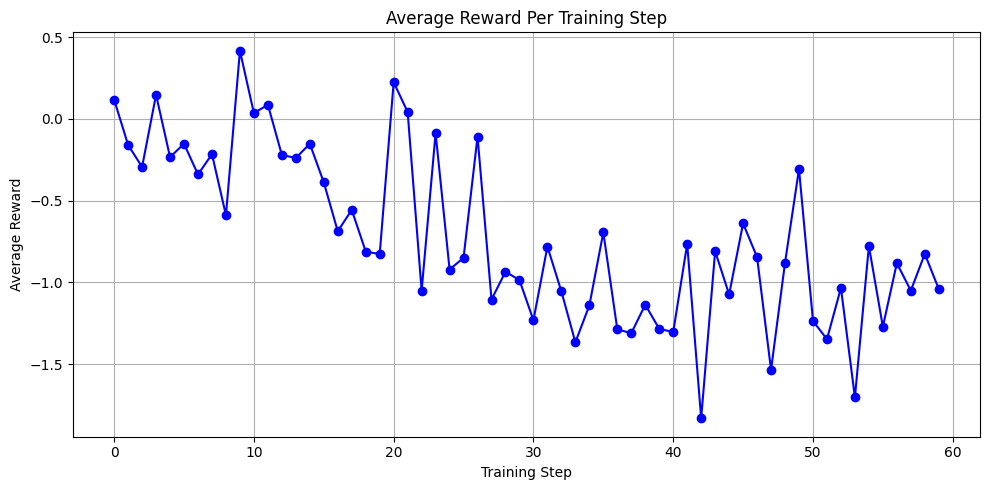

In [8]:
print("\n🚀 Starting RLHF training...")
rlhf_pipeline.train_step(training_prompts, steps=60)

In [9]:
print("\n📊 Evaluation after training:")
rlhf_pipeline.evaluate_model(test_prompts)


📊 Evaluation after training:
📊 Evaluating model performance...
📝 Prompt: What's the best way to start the day?
💬 Response:  By playing a football game, or a soccer game, or a baseball game, or a soccer game, or a football game, or a basketball game, or a football game, or a football game, or a soccer game, or a tennis game
🎯 Reward: -1.814
📝 Prompt: How do you deal with stress?
💬 Response: 

No.

No

No

No

No
No

No


No


No

No

No

No

No


No


No

🎯 Reward: -1.867
📝 Prompt: What's your advice for happiness?
💬 Response:  Not too much. Good. Good. You're good. Good. Good. Good. Good. Good. Good. Good. Good. Good. Good. Good. Good. Good. Good Good. Good Good Good Good Good Good Good Good Good
🎯 Reward: -0.063

📈 Avg Reward: -1.248


/tmp/ipython-input-10-169708462.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


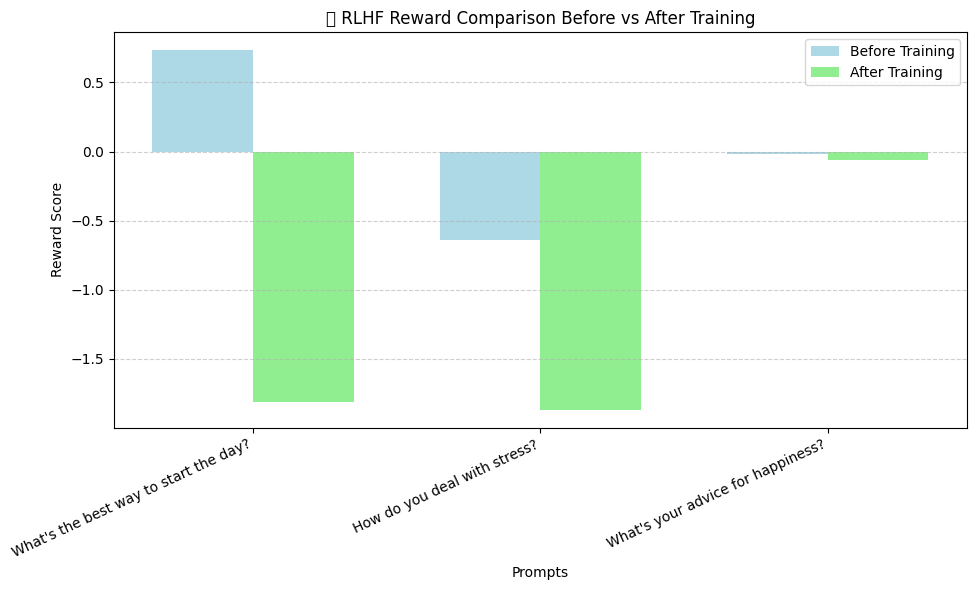

In [10]:
prompts = [
    "What's the best way to start the day?",
    "How do you deal with stress?",
    "What's your advice for happiness?"
]

rewards_before = [0.733, -0.641, -0.019]
rewards_after  = [-1.814,  -1.867, -0.063]

x = range(len(prompts))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, rewards_before, width=bar_width, label='Before Training', color='lightblue')
plt.bar([i + bar_width for i in x], rewards_after, width=bar_width, label='After Training', color='lightgreen')

plt.xlabel("Prompts")
plt.ylabel("Reward Score")
plt.title("📊 RLHF Reward Comparison Before vs After Training")
plt.xticks([i + bar_width / 2 for i in x], prompts, rotation=25, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()